<a href="https://colab.research.google.com/github/JeebakZ/Football-Scrapping-/blob/main/Zonal14_%26_HalfSpace_%5BFootball_Visualization%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [21]:
!pip install mplsoccer
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
import matplotlib.patches as patches

## Data collection & Filtering

In [22]:
# Function to extract JSON-like data from the HTML content
def extract_json_from_html(html_content, save_output=False):
    # Regular expression pattern to capture JSON-like data
    pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(pattern, html_content)

    if data_txt:
        # Replacing key strings for JSON compatibility
        data_txt = data_txt[0].replace('matchId', '"matchId"')\
            .replace('matchCentreData', '"matchCentreData"')\
            .replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')\
            .replace('formationIdNameMappings', '"formationIdNameMappings"')\
            .replace('};', '}')  # Fix the final closing bracket for valid JSON

        if save_output:
            # Optionally save the extracted data to a JSON file
            with open("output.json", "wt", encoding='utf-8') as output_file:
                output_file.write(data_txt)
        return data_txt  # Return the cleaned JSON string
    print("No JSON-like data found.")  # Handle case where no data is found
    return None

# Reading the HTML content from a file
html_path = r'/content/Turkiye 0-3 Portugal - European Championship 2024 Live.html'
with open(html_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Extract JSON-like data from the HTML content
json_data = extract_json_from_html(html_content, save_output=True)

# Parse the extracted JSON data if available
if json_data:
    try:
        data = json.loads(json_data)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")

# Function to extract relevant data from the JSON structure
def extract_data_from_dict(data):
    # Extract events and teams from the matchCentreData
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {
        data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
        data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']
    }

    # Create DataFrames for home and away players
    players_home = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_away = pd.DataFrame(data["matchCentreData"]['away']['players'])

    # Assign teamId for players
    players_home["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away["teamId"] = data["matchCentreData"]['away']['teamId']

    # Combine both home and away players into one DataFrame
    players_df = pd.concat([players_home, players_away])
    return events_dict, players_df, teams_dict

# Only process if JSON data was successfully extracted
if json_data:
    events_dict, players_df, teams_dict = extract_data_from_dict(data)

    # Save event and player data to CSV files
    pd.DataFrame(events_dict).to_csv('EventData.csv', index=False)
    players_df.to_csv('PlayerData.csv', index=False)

    # Load the saved CSVs for further processing
    df = pd.read_csv('EventData.csv')
    dfp = pd.read_csv('PlayerData.csv')

# Extract 'displayName' fields from type, outcomeType, and period columns
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

# Filter out corner and throw-in events, and keep only successful passes
df_filtered = df[~df['qualifiers'].str.contains('Corner|ThrowIn')]
df_filtered = df_filtered[(df_filtered['type'] == 'Pass') & (df_filtered['outcomeType'] == 'Successful')]

# Rescale the coordinates to match the 105x68 pitch dimensions
df_filtered[['x', 'endX']] *= 1.05
df_filtered[['y', 'endY']] *= 0.68

# Merge the filtered event data with player data on playerId
df_filtered = df_filtered.merge(dfp, on='playerId', how='left')

# Swap the x and y coordinates to adjust for correct pitch orientation
df_filtered[['x', 'y']] = df_filtered[['y', 'x']]
df_filtered[['endX', 'endY']] = df_filtered[['endY', 'endX']]

# Print the first few rows of the final DataFrame
print(df_filtered.head())


             id  eventId  minute  second  teamId_x       x       y  \
0  2.697250e+09        3       0     0.0       340  34.000  52.500   
1  2.697250e+09        4       0    16.0       333  30.940  15.750   
2  2.697250e+09        6       0    48.0       340  41.820   4.830   
3  2.697250e+09        7       0    52.0       340  20.196   4.410   
4  2.697250e+09        8       0    55.0       340  50.184   3.465   

   expandedMinute     period  type outcomeType  \
0               0  FirstHalf  Pass  Successful   
1               0  FirstHalf  Pass  Successful   
2               0  FirstHalf  Pass  Successful   
3               0  FirstHalf  Pass  Successful   
4               0  FirstHalf  Pass  Successful   

                                          qualifiers  \
0  [{'type': {'value': 140, 'displayName': 'PassE...   
1  [{'type': {'value': 141, 'displayName': 'PassE...   
2  [{'type': {'value': 140, 'displayName': 'PassE...   
3  [{'type': {'value': 212, 'displayName': 'Lengt...  

## Visualization for Zonal 14 & Halfspace

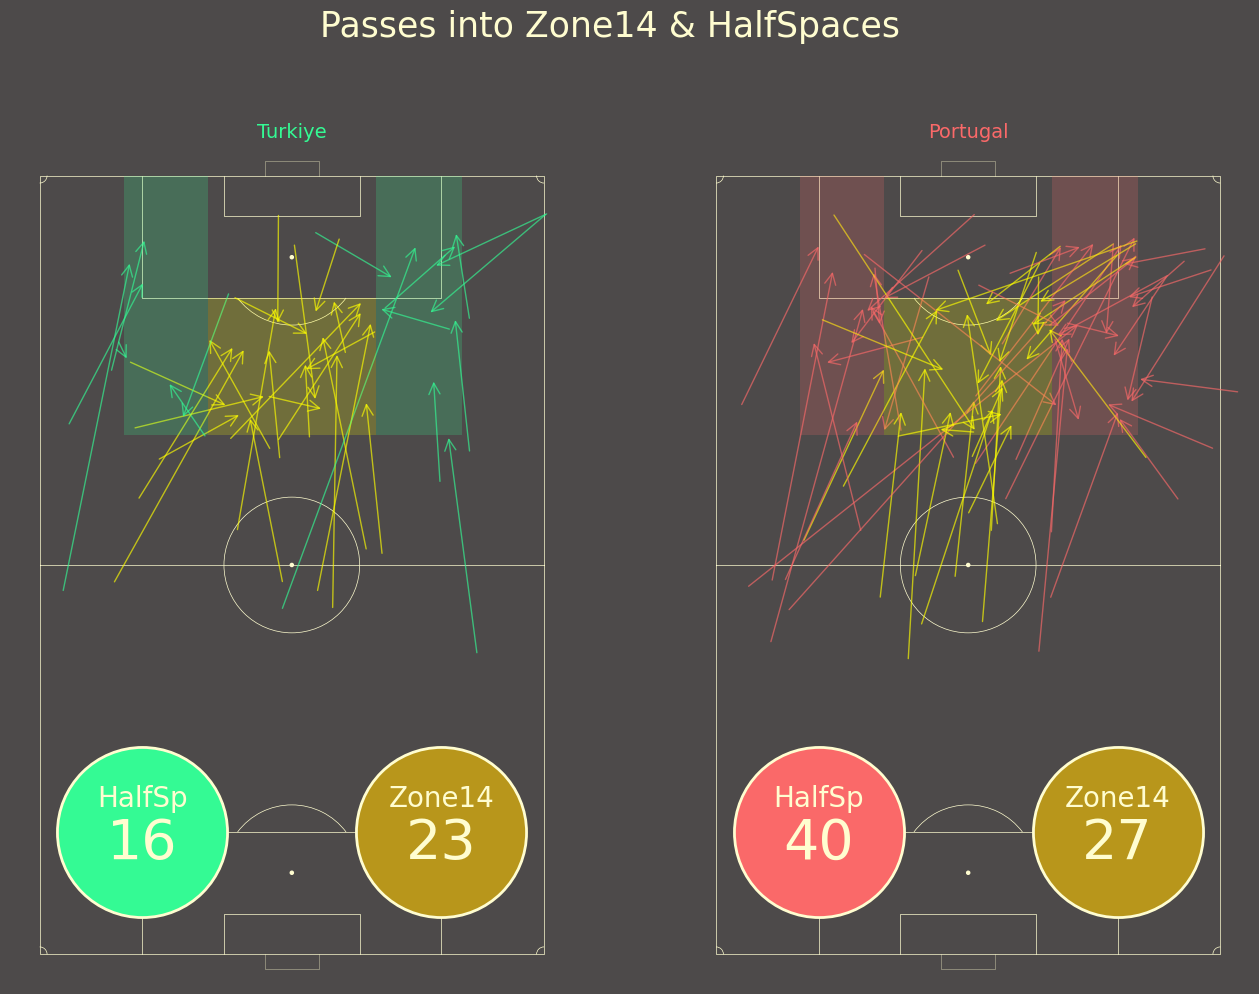

In [23]:
# Set up display options and colors
pd.set_option('display.max_columns', None)
black = '#4d4a4a'
white = '#fffdd0'
por = '#34fa94'
green = '#69f900'
tur = '#fa6969'

# Define teams and colors
hteamID = list(teams_dict.keys())[0]  # selected home team
ateamID = list(teams_dict.keys())[1]  # selected away team
hteamName= teams_dict[hteamID]
ateamName= teams_dict[ateamID]
hcol= por
acol= tur

# Filter successful passes (excluding corners)
dfhp = df.loc[df['teamId'] == hteamID]
dfhp = dfhp.loc[dfhp['type'] == "Pass"]
dfhp = dfhp.loc[dfhp['outcomeType'] == "Successful"]
dfhp = dfhp[~dfhp['qualifiers'].str.contains('Corner')]

dfap = df.loc[df['teamId'] == ateamID]
dfap = dfap.loc[dfap['type'] == "Pass"]
dfap = dfap.loc[dfap['outcomeType'] == "Successful"]
dfap = dfap[~dfap['qualifiers'].str.contains('Corner')]




def filter_passes(df, team_id):
    return df[(df['teamId'] == team_id) & (df['type'] == "Pass") & (df['outcomeType'] == "Successful") & ~df['qualifiers'].str.contains('Corner')]

dfhp = filter_passes(df, hteamID)
dfap = filter_passes(df, ateamID)

# Create a figure with a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 11), facecolor=black)

# Create a function to draw the shot maps
def draw_pass_map(ax, df, title, col):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=black, line_color=white, linewidth=0.5,
                          corner_arcs=True, goal_type='box', goal_alpha=.5)
    pitch.draw(ax=ax)
    ax.invert_xaxis()
    ax.set_facecolor(black)

    z14 = 0
    hs = 0

    for index, row in df.iterrows():
        if row['endY'] >= 70 and row['endY'] <= 88.54 and row['endX'] >= 22.66 and row['endX'] <= 45.32:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.65, mutation_scale=20, color='yellow', linewidth=1)
            ax.add_patch(arrow)
            z14 += 1
        if row['endY'] >= 70 and row['endX'] >= 11.33 and row['endX'] <= 22.66:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.65, mutation_scale=20, color=col, linewidth=1)
            ax.add_patch(arrow)
            hs += 1
        if row['endY'] >= 70 and row['endX'] >= 45.32 and row['endX'] <= 56.95:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.65, mutation_scale=20, color=col, linewidth=1)
            ax.add_patch(arrow)
            hs += 1

    x_z14 = [22.66, 22.66, 45.32, 45.32]
    y_z14 = [70, 88.54, 88.54, 70]
    ax.fill(x_z14, y_z14, 'yellow', alpha=0.2, label='Zone14')

    x_rhs = [11.33, 11.33, 22.66, 22.66]
    y_rhs = [70, 105, 105, 70]
    ax.fill(x_rhs, y_rhs, col, alpha=0.2, label='HalfSpaces')

    x_lhs = [45.32, 45.32, 56.95, 56.95]
    y_lhs = [70, 105, 105, 70]
    ax.fill(x_lhs, y_lhs, col, alpha=0.2, label='HalfSpaces')

    z14name = "Zone14"
    hsname = "HalfSp"
    z14count = f"{z14}"
    hscount = f"{hs}"
    ax.scatter(13.85, 16.46, color=col, s=15000, edgecolor=white, linewidth=2, alpha=1, marker='o')
    ax.scatter(54.15, 16.46, color='#b8961b', s=15000, edgecolor=white, linewidth=2, alpha=1, marker='o')
    ax.text(13.85, 21, hsname, fontsize=20, color=white, ha='center', va='center')
    ax.text(54.15, 21, z14name, fontsize=20, color=white, ha='center', va='center')
    ax.text(13.85, 15, hscount, fontsize=40, color=white, ha='center', va='center')
    ax.text(54.15, 15, z14count, fontsize=40, color=white, ha='center', va='center')
    ax.set_title(title, color=col, fontsize=14)

# You need to provide values for `dfhp`, `dfap`, `hteamName`, `hcol`, `ateamName`, and `acol`
draw_pass_map(axs[0], dfhp, hteamName, hcol)
draw_pass_map(axs[1], dfap, ateamName, acol)

plt.suptitle(f'Passes into Zone14 & HalfSpaces', fontsize=25, color=white, y=1)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'Passes_into_Danger_zone.png', bbox_inches='tight')
